# Propensity Score Matching For Single-Theme Groups

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import pymatch
import warnings
warnings.filterwarnings('ignore')
from pymatch.Matcher import Matcher

In [37]:
df = pd.read_csv('propensity_features_v1.csv')

In [38]:
df.head()

,userid,gender,days_since_confirmed,l28,num_groups,cityid,age,sotg
0,100045368494055,1,324.0,28,10.0,2523270.0,20.0,0
1,100027405470013,1,850.0,28,477.0,1382466.0,31.0,1
2,100051619193068,1,169.0,28,19.0,2408193.0,60.0,1
3,100014395184000,1,1440.0,28,63.0,2413375.0,21.0,0
4,100007666265988,2,2484.0,28,34.0,2498812.0,19.0,1


In [39]:
df.drop('cityid', axis = 1, inplace = True)
df.head()

,userid,gender,days_since_confirmed,l28,num_groups,age,sotg
0,100045368494055,1,324.0,28,10.0,20.0,0
1,100027405470013,1,850.0,28,477.0,31.0,1
2,100051619193068,1,169.0,28,19.0,60.0,1
3,100014395184000,1,1440.0,28,63.0,21.0,0
4,100007666265988,2,2484.0,28,34.0,19.0,1


## MUST READ: you have to edit the pymatch package class before using the package, really you dont even need to download it, just copy the class in the cell below, you must edit the last function in the class for it to work properly

In [46]:
#MUST EDIT THE LAST FUNCTION IN THIS 
from __future__ import print_function
from pymatch import *
import pymatch.functions as uf

class Matcher:
    """
    Matcher Class -- Match data for an observational study.

    Parameters
    ----------
    test : pd.DataFrame
        Data representing the test group
    control : (pd.DataFrame)
        Data representing the control group
    formula : str (optional)
        custom formula to use for logistic regression
        i.e. "Y ~ x1 + x2 + ..."
    yvar : str (optional)
        Name of dependent variable (the treatment)
    exclude : list  (optional)
        List of variables to ignore in regression/matching.
        Useful for unique idenifiers
    """

    def __init__(self, test, control, yvar, formula=None, exclude=[]):
        # configure plots for ipynb
        plt.rcParams["figure.figsize"] = (10, 5)
        # variables generated during matching
        aux_match = ['scores', 'match_id', 'weight', 'record_id']
        # assign unique indices to test and control
        t, c = [i.copy().reset_index(drop=True) for i in (test, control)]
        t = t.dropna(axis=1, how="all")
        c = c.dropna(axis=1, how="all")
        c.index += len(t)
        self.data = t.dropna(axis=1, how='all').append(c.dropna(axis=1, how='all')).dropna()
        self.control_color = "#1F77B4"
        self.test_color = "#FF7F0E"
        self.yvar = yvar
        self.exclude = exclude + [self.yvar] + aux_match
        self.formula = formula
        self.nmodels = 1  # for now
        self.models = []
        self.swdata = None
        self.model_accuracy = []
        self.data[yvar] = self.data[yvar].astype(int)  # should be binary 0, 1
        self.xvars = [i for i in self.data.columns if i not in self.exclude and i != yvar]
        self.matched_data = []
        self.y, self.X = patsy.dmatrices('{} ~ {}'.format(yvar, '+'.join(self.xvars)), data=self.data,
                                         return_type='dataframe')
        self.xvars = [i for i in self.data.columns if i not in self.exclude]
        self.test= self.data[self.data[yvar] == True]
        self.control = self.data[self.data[yvar] == False]
        self.testn = len(self.test)
        self.controln = len(self.control)
        self.minority, self.majority = \
          [i[1] for i in sorted(zip([self.testn, self.controln], [1, 0]),
                                key=lambda x: x[0])]
        print('Formula:\n{} ~ {}'.format(yvar, '+'.join(self.xvars)))
        print('n majority:', len(self.data[self.data[yvar] == self.majority]))
        print('n minority:', len(self.data[self.data[yvar] == self.minority]))

    def fit_scores(self, balance=True, nmodels=None):
        """
        Fits logistic regression model(s) used for
        generating propensity scores

        Parameters
        ----------
        balance : bool
            Should balanced datasets be used?
            (n_control == n_test)
        nmodels : int
            How many models should be fit?
            Score becomes the average of the <nmodels> models if nmodels > 1

        Returns
        -------
        None
        """
        # reset models if refitting
        if len(self.models) > 0:
            self.models = []
        if len(self.model_accuracy) > 0:
            self.model_accuracy = []
        if not self.formula:
            # use all columns in the model
            self.formula = '{} ~ {}'.format(self.yvar, '+'.join(self.xvars))
        if balance:
            if nmodels is None:
                # fit multiple models based on imbalance severity (rounded up to nearest tenth)
                minor, major = [self.data[self.data[self.yvar] == i] for i in (self.minority, self.majority)]
                nmodels = int(np.ceil((len(major) / len(minor)) / 10) * 10)
            self.nmodels = nmodels
            i = 0
            errors = 0
            while i < nmodels and errors < 5:
                uf.progress(i+1, nmodels,
                            prestr="Fitting Models on Balanced Samples")

                # sample from majority to create balance dataset
                df = self.balanced_sample()
                df = pd.concat([uf.drop_static_cols(df[df[self.yvar] == 1], yvar=self.yvar),
                                uf.drop_static_cols(df[df[self.yvar] == 0], yvar=self.yvar)])
                y_samp, X_samp = patsy.dmatrices(self.formula, data=df, return_type='dataframe')
                X_samp.drop(self.yvar, axis=1, errors='ignore', inplace=True)

                glm = GLM(y_samp, X_samp, family=sm.families.Binomial())
                try:
                    res = glm.fit()
                    self.model_accuracy.append(self._scores_to_accuracy(res, X_samp, y_samp))
                    self.models.append(res)
                    i += 1
                except Exception as e:
                    errors += 1 # to avoid infinite loop for misspecified matrix
                    print('Error: {}'.format(e))

            print("\nAverage Accuracy:", "{}%".
                  format(round(np.mean(self.model_accuracy) * 100, 2)))
        else:
            # ignore any imbalance and fit one model
            print('Fitting 1 (Unbalanced) Model...')
            glm = GLM(self.y, self.X, family=sm.families.Binomial())
            res = glm.fit()
            self.model_accuracy.append(self._scores_to_accuracy(res, self.X, self.y))
            self.models.append(res)
            print("\nAccuracy", round(np.mean(self.model_accuracy[0]) * 100, 2))


    def predict_scores(self):
        """
        Predict Propensity scores for each observation.
        Adds a "scores" columns to self.data

        Returns
        -------
        None
        """
        scores = np.zeros(len(self.X))
        for i in range(self.nmodels):
            m = self.models[i]
            scores += m.predict(self.X[m.params.index])
        self.data['scores'] = scores/self.nmodels

    def match(self, threshold=0.001, nmatches=1, method='min', max_rand=10):
        """
        Finds suitable match(es) for each record in the minority
        dataset, if one exists. Records are exlcuded from the final
        matched dataset if there are no suitable matches.

        self.matched_data contains the matched dataset once this
        method is called

        Parameters
        ----------
        threshold : float
            threshold for fuzzy matching matching
            i.e. |score_x - score_y| >= theshold
        nmatches : int
            How majority profiles should be matched
            (at most) to minority profiles
        method : str
            Strategy for when multiple majority profiles
            are suitable matches for a single minority profile
            "random" - choose randomly (fast, good for testing)
            "min" - choose the profile with the closest score
        max_rand : int
            max number of profiles to consider when using random tie-breaks

        Returns
        -------
        None
        """
        if 'scores' not in self.data.columns:
            print("Propensity Scores have not been calculated. Using defaults...")
            self.fit_scores()
            self.predict_scores()
        test_scores = self.data[self.data[self.yvar]==True][['scores']]
        ctrl_scores = self.data[self.data[self.yvar]==False][['scores']]
        result, match_ids = [], []
        for i in range(len(test_scores)):
            # uf.progress(i+1, len(test_scores), 'Matching Control to Test...')
            match_id = i
            score = test_scores.iloc[i]
            if method == 'random':
                bool_match = abs(ctrl_scores - score) <= threshold
                matches = ctrl_scores.loc[bool_match[bool_match.scores].index]
            elif method == 'min':
                matches = abs(ctrl_scores - score).sort_values('scores').head(nmatches)
            else:
                raise(AssertionError, "Invalid method parameter, use ('random', 'min')")
            if len(matches) == 0:
                continue
            # randomly choose nmatches indices, if len(matches) > nmatches
            select = nmatches if method != 'random' else np.random.choice(range(1, max_rand+1), 1)
            chosen = np.random.choice(matches.index, min(select, nmatches), replace=False)
            result.extend([test_scores.index[i]] + list(chosen))
            match_ids.extend([i] * (len(chosen)+1))
        self.matched_data = self.data.loc[result]
        self.matched_data['match_id'] = match_ids
        self.matched_data['record_id'] = self.matched_data.index

    def select_from_design(self, cols):
        d = pd.DataFrame()
        for c in cols:
            d = pd.concat([d, self.X.select(lambda x: x.startswith(c), axis=1)], axis=1)
        return d

    def balanced_sample(self, data=None):
        if not data:
            data=self.data
        minor, major = data[data[self.yvar] == self.minority], data[data[self.yvar] == self.majority]
        return major.sample(len(minor)).append(minor).dropna()

    def plot_scores(self):
        """
        Plots the distribution of propensity scores before matching between
        our test and control groups
        """
        assert 'scores' in self.data.columns, "Propensity scores haven't been calculated, use Matcher.predict_scores()"
        sns.distplot(self.data[self.data[self.yvar]==0].scores, label='Control')
        sns.distplot(self.data[self.data[self.yvar]==1].scores, label='Test')
        plt.legend(loc='upper right')
        plt.xlim((0, 1))
        plt.title("Propensity Scores Before Matching")
        plt.ylabel("Percentage (%)")
        plt.xlabel("Scores")

    def prop_test(self, col):
        """
        Performs a Chi-Square test of independence on <col>
        See stats.chi2_contingency()

        Parameters
        ----------
        col : str
            Name of column on which the test should be performed

        Returns
        ______
        dict
            {'var': <col>,
             'before': <pvalue before matching>,
             'after': <pvalue after matching>}


        """
        if not uf.is_continuous(col, self.X) and col not in self.exclude:
            pval_before = round(stats.chi2_contingency(self.prep_prop_test(self.data, col))[1], 6)
            pval_after = round(stats.chi2_contingency(self.prep_prop_test(self.matched_data, col))[1], 6)
            return {'var':col, 'before':pval_before, 'after':pval_after}
        else:
            print("{} is a continuous variable".format(col))

    def compare_continuous(self, save=False, return_table=False):
        """
        Plots the ECDFs for continuous features before and
        after matching. Each chart title contains test results
        and statistics to summarize how similar the two distributions
        are (we want them to be close after matching).

        Tests performed:
        Kolmogorov-Smirnov Goodness of fit Test (KS-test)
            This test statistic is calculated on 1000
            permuted samples of the data, generating
            an imperical p-value.  See pymatch.functions.ks_boot()
            This is an adaptation of the ks.boot() method in
            the R "Matching" package
            https://www.rdocumentation.org/packages/Matching/versions/4.9-2/topics/ks.boot
        Chi-Square Distance:
            Similarly this distance metric is calculated on
            1000 permuted samples.
            See pymatch.functions.grouped_permutation_test()

        Other included Stats:
        Standarized mean and median differences
        How many standard deviations away are the mean/median
        between our groups before and after matching
        i.e. abs(mean(control) - mean(test)) / std(control.union(test))

        Parameters
        ----------
        return_table : bool
            Should the function a table with tests and statistics?

        Returns
        -------
        pd.DataFrame (optional)
            Table of before/after statistics if return_table == True


        """
        test_results = []
        for col in self.matched_data.columns:
            if uf.is_continuous(col, self.X) and col not in self.exclude:
                # organize data
                trb, cob = self.test[col], self.control[col]
                tra = self.matched_data[self.matched_data[self.yvar]==True][col]
                coa = self.matched_data[self.matched_data[self.yvar]==False][col]
                xtb, xcb = ECDF(trb), ECDF(cob)
                xta, xca = ECDF(tra),ECDF(coa)

                # before/after stats
                std_diff_med_before, std_diff_mean_before = uf.std_diff(trb, cob)
                std_diff_med_after, std_diff_mean_after = uf.std_diff(tra, coa)
                pb, truthb = uf.grouped_permutation_test(uf.chi2_distance, trb, cob)
                pa, trutha = uf.grouped_permutation_test(uf.chi2_distance, tra, coa)
                ksb = round(uf.ks_boot(trb, cob, nboots=1000), 6)
                ksa = round(uf.ks_boot(tra, coa, nboots=1000), 6)

                # plotting
                f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 5))
                ax1.plot(xcb.x, xcb.y, label='Control', color=self.control_color)
                ax1.plot(xtb.x, xtb.y, label='Test', color=self.test_color)
                ax1.plot(xcb.x, xcb.y, label='Control', color=self.control_color)
                ax1.plot(xtb.x, xtb.y, label='Test', color=self.test_color)

                title_str = '''
                ECDF for {} {} Matching
                KS p-value: {}
                Grouped Perm p-value: {}
                Std. Median Difference: {}
                Std. Mean Difference: {}
                '''
                ax1.set_title(title_str\
                  .format(col, "before", ksb, pb, std_diff_med_before, std_diff_mean_before))
                ax2.plot(xca.x, xca.y, label='Control')
                ax2.plot(xta.x, xta.y, label='Test')
                ax2.set_title(title_str\
                  .format(col, "after", ksa, pa, std_diff_med_after, std_diff_mean_after))
                ax2.legend(loc="lower right")
                plt.xlim((0, np.percentile(xta.x, 99)))

                test_results.append({
                        "var": col,
                        "ks_before": ksb,
                        "ks_after": ksa,
                        "grouped_chisqr_before": pb,
                        "grouped_chisqr_after": pa,
                        "std_median_diff_before": std_diff_med_before,
                        "std_median_diff_after": std_diff_med_after,
                        "std_mean_diff_before": std_diff_mean_before,
                        "std_mean_diff_after": std_diff_mean_after
                    })

        var_order = [
                    "var",
                    "ks_before",
                    "ks_after",
                    "grouped_chisqr_before",
                    "grouped_chisqr_after",
                    "std_median_diff_before",
                    "std_median_diff_after",
                    "std_mean_diff_before",
                    "std_mean_diff_after"
                ]

        return pd.DataFrame(test_results)[var_order] if return_table else None

    def compare_categorical(self, return_table=False):
        """
        Plots the proportional differences of each enumerated
        discete column for test and control.
        i.e. <prop_test_that_have_x>  - <prop_control_that_have_x>
        Each chart title contains the results from a
        Chi-Square Test of Independence before and after
        matching.
        See pymatch.prop_test()

        Parameters
        ----------
        return_table : bool
            Should the function return a table with
            test results?

        Return
        ------
        pd.DataFrame() (optional)
            Table with the p-values of the Chi-Square contingency test
            for each discrete column before and after matching

        """
        def prep_plot(data, var, colname):
            t, c = data[data[self.yvar] == 1], data[data[self.yvar] == 0]
            # dummy var for counting
            dummy = [i for i in t.columns if i not in \
                      (var, "match_id", "record_id", "weight")][0]
            countt = t[[var, dummy]].groupby(var).count() / len(t)
            countc = c[[var, dummy]].groupby(var).count() / len(c)
            ret = (countt-countc).dropna()
            ret.columns = [colname]
            return ret

        title_str = '''
        Proportional Difference (test-control) for {} Before and After Matching
        Chi-Square Test for Independence p-value before | after:
        {} | {}
        '''
        test_results = []
        for col in self.matched_data.columns:
            if not uf.is_continuous(col, self.X) and col not in self.exclude:
                dbefore = prep_plot(self.data, col, colname="before")
                dafter = prep_plot(self.matched_data, col, colname="after")
                df = dbefore.join(dafter)
                test_results_i = self.prop_test(col)
                test_results.append(test_results_i)

                # plotting
                df.plot.bar(alpha=.8)
                plt.title(title_str.format(col, test_results_i["before"], test_results_i["after"]))
                lim = max(.09, abs(df).max().max()) + .01
                plt.ylim((-lim, lim))
        return pd.DataFrame(test_results)[['var', 'before', 'after']] if return_table else None

    def prep_prop_test(self, data, var):
        """
        Helper method for running chi-square contingency tests

        Balances the counts of discrete variables with our groups
        so that missing levels are replaced with 0.
        i.e. if the test group has no records with x as a field
        for a given column, make sure the count for x is 0
        and not missing.

        Parameters
        ----------
        data : pd.DataFrame()
            Data to use for counting
        var : str
            Column to use within data

        Returns
        -------
        list
            A table (list of lists) of counts for all enumerated field within <var>
            for test and control groups.
        """
        counts = data.groupby([var, self.yvar]).count().reset_index()
        table = []
        for t in (0, 1):
            os_counts = counts[counts[self.yvar] ==t]\
                                     .sort_values(var)
            cdict = {}
            for row in os_counts.iterrows():
                row = row[1]
                cdict[row[var]] = row[2]
            table.append(cdict)
        # fill empty keys as 0
        all_keys = set(chain.from_iterable(table))
        for d in table:
            d.update((k, 0) for k in all_keys if k not in d)
        ctable = [[i[k] for k in sorted(all_keys)] for i in table]
        return ctable

    def prop_retained(self):
        """
        Returns the proportion of data retained after matching
        """
        return len(self.matched_data[self.matched_data[self.yvar] == self.minority]) * 1.0 / \
               len(self.data[self.data[self.yvar] == self.minority])

    def tune_threshold(self, method, nmatches=1, rng=np.arange(0, .001, .0001)):
        """
        Matches data over a grid to optimize threshold value and plots results.

        Parameters
        ----------
        method : str
            Method used for matching (use "random" for this method)
        nmatches : int
            Max number of matches per record. See pymatch.match()
        rng: : list / np.array()
            Grid of threshold values

        Returns
        -------
        None

        """
        results = []
        for i in rng:
            self.match(method=method, nmatches=nmatches, threshold=i)
            results.append(self.prop_retained())
        plt.plot(rng, results)
        plt.title("Proportion of Data retained for grid of threshold values")
        plt.ylabel("Proportion Retained")
        plt.xlabel("Threshold")
        plt.xticks(rng)

    def record_frequency(self):
        """
        Calculates the frequency of specifi records in
        the matched dataset

        Returns
        -------
        pd.DataFrame()
            Frequency table of the number records
            matched once, twice, ..., etc.
        """
        freqs = self.matched_data.groupby("record_id")\
                    .count().groupby("match_id").count()\
                    [["scores"]].reset_index()
        freqs.columns = ["freq", "n_records"]
        return freqs

    def assign_weight_vector(self):
        record_freqs = self.matched_data.groupby("record_id")\
                           .count()[['match_id']].reset_index()
        record_freqs.columns = ["record_id", "weight"]
        fm = record_freqs.merge(self.matched_data, on="record_id")
        fm['weight'] = 1/fm['weight']
        self.matched_data = fm

        
######YOU BETTER READ THIS -- https://github.com/benmiroglio/pymatch/issues/23 -- YOU GOTTA CREATE THE CLASS YOURSELF 
    @staticmethod
    def _scores_to_accuracy(m, X, y):
        preds = [1.0 if i >= .5 else 0.0 for i in m.predict(X)]
        # return (y == preds).sum() * 1.0 / len(y)
        return (y.to_numpy().T == preds).sum() * 1.0 / len(y)


In [47]:
test = df[df['sotg']==1]
control = df[df['sotg']==0]
m = Matcher(test, control, yvar='sotg', exclude=['userid'])

Formula:
sotg ~ gender+days_since_confirmed+l28+num_groups+age
n majority: 317544
n minority: 194843


In [49]:
#note! IF YOU ARE GETTING A WEIRD OUTPUT HERE THEN YOU NEED TO READ [46]
np.random.seed(20170925)
m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 59.84%


In [50]:
#this assigns a propensity score to each userid
m.predict_scores()

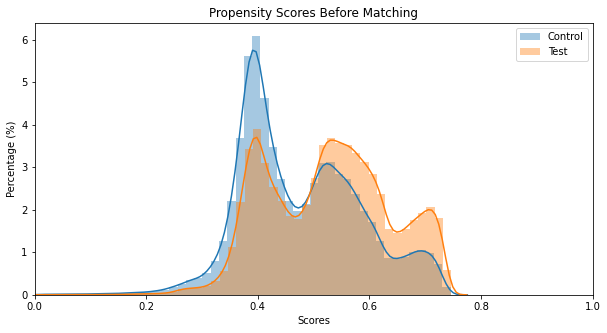

In [51]:
m.plot_scores()

In [54]:
m.tune_threshold(method='random')

KeyboardInterrupt: 

In [ ]:
m.match(method="min", nmatches=1, threshold=0.0001)
m.record_frequency()

In [ ]:
#categorical_results = m.compare_categorical(return_table=True)
cc = m.compare_continuous(return_table=True)